## Initialization

In [ ]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np

from model2 import UNet

## Pre-processing Dataset

In [2]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [3]:
path = Path("dataset/imagesTr/")
subjects_paths = list(path.glob("*.nii.gz"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"MRI":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)    

In [4]:
for subject in subjects:
    label_map = subject["Label"].data.squeeze().numpy()
    label_map[np.logical_or(label_map == 1, label_map == 2)] = 1
    label_map = label_map[np.newaxis, ...]  
    subject["Label"].set_data(torch.from_numpy(label_map))

In [5]:
for subject in subjects:
    assert subject["MRI"].orientation == ("R", "A", "S")

In [6]:
process = tio.Compose([
            tio.CropOrPad((64, 64, 64)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

In [9]:
train_dataset = tio.SubjectsDataset(subjects[:208], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[208:], transform=val_transform)

sampler = tio.data.LabelSampler(
    patch_size=64,
    label_name="Label",
    label_probabilities={0: 0.2, 1: 0.8}  # 0: background, 1: Hippocampus (foreground)
)

In [13]:
train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=4,
    )

In [14]:
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)

## Model Creation

In [15]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.train_losses = []
        self.val_losses = []
        self.train_loss_epoch = 0.0
        self.val_loss_epoch = 0.0
        self.total_train_batches = 0
        self.total_val_batches = 0
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        img = batch["MRI"]["data"]
        mask = batch["Label"]["data"][:, 0]  
        mask = mask.long()
        
        pred = self(img)        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Loss", loss)

        self.train_loss_epoch += loss.item()
        self.total_train_batches += 1
        
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        img = batch["MRI"]["data"]
        mask = batch["Label"]["data"][:, 0]  
        mask = mask.long()

        pred = self(img)        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Loss", loss)
        
        self.val_loss_epoch += loss.item()
        self.total_val_batches += 1
        
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    def log_images(self, img, pred, mask, name):
        results = []
        pred = torch.argmax(pred, 1)
        
        axial_slice = 50  

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:, :, axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:, :, axial_slice] == 0, mask[0][:, :, axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(img[0][0][:, :, axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:, :, axial_slice] == 0, pred[0][:, :, axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

    
    def configure_optimizers(self):
        return [self.optimizer]
    
    def on_train_epoch_end(self):
        avg_train_loss = self.train_loss_epoch / self.total_train_batches
        self.train_losses.append(avg_train_loss)
        
        self.train_loss_epoch = 0.0
        self.total_train_batches = 0
    
    def on_validation_epoch_end(self):
        avg_val_loss = self.val_loss_epoch / self.total_val_batches
        self.val_losses.append(avg_val_loss)
        
        self.val_loss_epoch = 0.0
        self.total_val_batches = 0

## Training Model

In [17]:
model = Segmenter()

In [18]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [19]:
trainer = pl.Trainer(accelerator="gpu", devices="auto", logger=TensorBoardLogger(save_dir="trained-model/logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('A100-SXM4-40GB MIG 7g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 5.8 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.344    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/riset/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/riset/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/home/riset/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


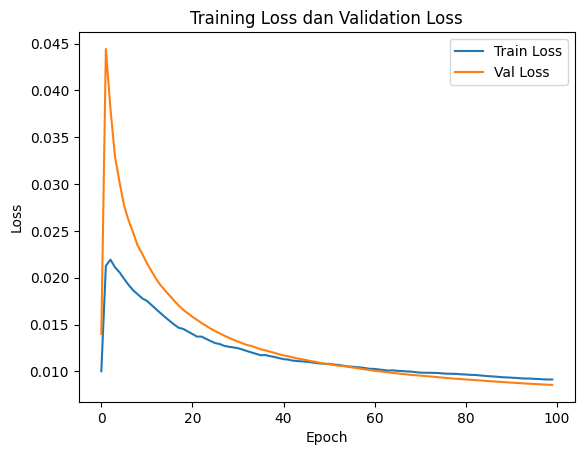

In [64]:
train_losses = model.train_losses
val_losses = model.val_losses

# Calculate the average loss per epoch
avg_train_losses = [sum(train_losses) / len(train_losses)]
avg_val_losses = [sum(val_losses) / len(val_losses)]
for i in range(1, len(train_losses)):
    avg_train_losses.append(avg_train_losses[-1] + (train_losses[i] - avg_train_losses[-1]) / (i + 1))
    avg_val_losses.append(avg_val_losses[-1] + (val_losses[i] - avg_val_losses[-1]) / (i + 1))

epochs = range(len(avg_train_losses))
plt.plot(epochs, avg_train_losses, label='Train Loss')
plt.plot(epochs, avg_val_losses, label='Val Loss')
plt.title('Training Loss dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("result/loss.png")
plt.show()

In [ ]:
import csv

with open('result/losses.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])
    for epoch, train_loss in enumerate(train_losses, 1):
        val_loss = val_losses[epoch - 1]  
        writer.writerow([epoch, train_loss, val_loss])

In [24]:
torch.save(model.state_dict(), "trained-model/model-weights.pth")

In [25]:
torch.save(model, "trained-model/model-entire.pt")

In [26]:
torch.save({'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': torch.optim.Adam(model.parameters(), lr=1e-4),
            'loss': torch.nn.CrossEntropyLoss()}, 
            'trained-model/model-checkpoint.pt')

## Testing Model along with Evaluation and Analysis

In [22]:
from IPython.display import HTML
from celluloid import Camera


In [23]:
model = Segmenter.load_from_checkpoint("trained-model/logs/epoch=97-step=50960.ckpt")
model = model.eval()
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [20]:
iou_scores = []
predicted_masks = []  

for i in range(len(val_dataset)):
    mask = val_dataset[i]["Label"]["data"]
    imgs = val_dataset[i]["MRI"]["data"]
    
    grid_sampler = tio.inference.GridSampler(val_dataset[i], 64, (8, 8, 8))

    aggregator = tio.inference.GridAggregator(grid_sampler)

    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

    with torch.no_grad():
        for patches_batch in patch_loader:
            input_tensor = patches_batch['MRI']["data"].to(device) 
            locations = patches_batch[tio.LOCATION] 
            pred = model(input_tensor) 
            aggregator.add_batch(pred, locations)  

    output_tensor = aggregator.get_output_tensor()
    pred = output_tensor.argmax(0) 

    output_array = pred.detach().cpu().numpy()
    mask = torch.from_numpy(mask.numpy().squeeze().astype(np.int64))  # remove channel dimension
    predicted_mask = torch.from_numpy(output_array.squeeze().astype(np.int64))  # remove channel dimension
    intersection = np.logical_and(mask, predicted_mask).sum()
    union = np.logical_or(mask, predicted_mask).sum()
    iou = intersection / union
    iou_scores.append(iou)
    predicted_masks.append(predicted_mask)

average_iou_score = np.mean(iou_scores)
print("Average Score is", average_iou_score)

worst_iou_idx = np.argmin(iou_scores)
best_iou_idx = np.argmax(iou_scores)
worst_iou = iou_scores[worst_iou_idx]
best_iou = iou_scores[best_iou_idx]
worst_predicted_mask = predicted_masks[worst_iou_idx]
best_predicted_mask = predicted_masks[best_iou_idx]
print("Worst IoU Score is", worst_iou, "at index", worst_iou_idx)
print("Best IoU Score is", best_iou, "at index", best_iou_idx)

Average Score is 0.8301023
Worst IoU Score is tensor(0.7178) at index 7
Best IoU Score is tensor(0.8996) at index 20


In [21]:
dice_scores = []
predicted_masks = []

for i in range(len(val_dataset)):
    mask = val_dataset[i]["Label"]["data"]
    imgs = val_dataset[i]["MRI"]["data"]

    grid_sampler = tio.inference.GridSampler(val_dataset[i], 64, (8, 8, 8))

    aggregator = tio.inference.GridAggregator(grid_sampler)

    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

    with torch.no_grad():
        for patches_batch in patch_loader:
            input_tensor = patches_batch['MRI']["data"].to(device) 
            locations = patches_batch[tio.LOCATION] 
            pred = model(input_tensor)  
            aggregator.add_batch(pred, locations)  

    output_tensor = aggregator.get_output_tensor()
    pred = output_tensor.argmax(0) 

    output_array = pred.detach().cpu().numpy()
    mask = torch.from_numpy(mask.numpy().squeeze().astype(np.int64))  
    predicted_mask = torch.from_numpy(output_array.squeeze().astype(np.int64))  
    intersection = np.logical_and(mask, predicted_mask).sum()
    union = mask.sum() + predicted_mask.sum()
    dice = (2.0 * intersection) / union
    dice_scores.append(dice)
    predicted_masks.append(predicted_mask)

average_dice_score = np.mean(dice_scores)
print("Average Score is", average_dice_score)

worst_dice_idx = np.argmin(dice_scores)
best_dice_idx = np.argmax(dice_scores)
worst_dice = dice_scores[worst_dice_idx]
best_dice = dice_scores[best_dice_idx]
worst_predicted_mask = predicted_masks[worst_dice_idx]
best_predicted_mask = predicted_masks[best_dice_idx]
print("Worst Dice Score is", worst_dice, "at index", worst_dice_idx)
print("Best Dice Score is", best_dice, "at index", best_dice_idx)

Average Score is 0.90670246
Worst Dice Score is tensor(0.8357) at index 7
Best Dice Score is tensor(0.9471) at index 20


In [22]:
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []

for i in range(len(val_dataset)):
    mask = val_dataset[i]["Label"]["data"]
    imgs = val_dataset[i]["MRI"]["data"]

    grid_sampler = tio.inference.GridSampler(val_dataset[i], 64, (8, 8, 8))

    aggregator = tio.inference.GridAggregator(grid_sampler)

    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

    with torch.no_grad():
        for patches_batch in patch_loader:
            input_tensor = patches_batch['MRI']["data"].to(device)  # Get batch of patches
            locations = patches_batch[tio.LOCATION]  # Get locations of patches
            pred = model(input_tensor)  # Compute prediction
            aggregator.add_batch(pred, locations)  # Combine predictions to volume

    output_tensor = aggregator.get_output_tensor()
    pred = output_tensor.argmax(0)  # Convert 4D tensor to 3D tensor

    output_array = pred.detach().cpu().numpy()

    mask = mask.numpy().squeeze().astype(np.int64)  # remove channel dimension
    predicted_mask = output_array.squeeze().astype(np.int64)  # remove channel dimension

    TP = np.sum(np.logical_and(mask == 1, predicted_mask == 1))
    TN = np.sum(np.logical_and(mask == 0, predicted_mask == 0))
    FP = np.sum(np.logical_and(mask == 0, predicted_mask == 1))
    FN = np.sum(np.logical_and(mask == 1, predicted_mask == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    accuracy_scores.append(accuracy)
    sensitivity_scores.append(sensitivity)
    specificity_scores.append(specificity)

average_sensitivity = np.mean(sensitivity_scores)
average_specificity = np.mean(specificity_scores)
average_accuracy = np.mean(accuracy_scores)

print("Average Sensitivity Score is", average_sensitivity)
print("Average Specificity Score is", average_specificity)
print("Average Accuracy Score is", average_accuracy)

worst_sensitivity_idx = np.argmin(sensitivity_scores)
best_sensitivity_idx = np.argmax(sensitivity_scores)
worst_sensitivity = sensitivity_scores[worst_sensitivity_idx]
best_sensitivity = sensitivity_scores[best_sensitivity_idx]
worst_predicted_mask = predicted_masks[worst_sensitivity_idx]
best_predicted_mask = predicted_masks[best_sensitivity_idx]

worst_specificity_idx = np.argmin(specificity_scores)
best_specificity_idx = np.argmax(specificity_scores)
worst_specificity = specificity_scores[worst_specificity_idx]
best_specificity = specificity_scores[best_specificity_idx]

worst_accuracy_idx = np.argmin(accuracy_scores)
best_accuracy_idx = np.argmax(accuracy_scores)
worst_accuracy = accuracy_scores[worst_accuracy_idx]
best_accuracy = accuracy_scores[best_accuracy_idx]

print("Worst Sensitivity Score is", worst_sensitivity, "at index", worst_sensitivity_idx)
print("Best Sensitivity Score is", best_sensitivity, "at index", best_sensitivity_idx)

print("Worst Specificity Score is", worst_specificity, "at index", worst_specificity_idx)
print("Best Specificity Score is", best_specificity, "at index", best_specificity_idx)

print("Worst Accuracy Score is", worst_accuracy, "at index", worst_accuracy_idx)
print("Best Accuracy Score is", best_accuracy, "at index", best_accuracy_idx)

Average Sensitivity Score is 0.904152422499039
Average Specificity Score is 0.9988049877062533
Average Accuracy Score is 0.997555659367488
Worst Sensitivity Score is 0.8091947913898485 at index 7
Best Sensitivity Score is 0.9574468085106383 at index 24
Worst Specificity Score is 0.9978117737436129 at index 33
Best Specificity Score is 0.9995131055749412 at index 19
Worst Accuracy Score is 0.9953079223632812 at index 8
Best Accuracy Score is 0.9985809326171875 at index 20


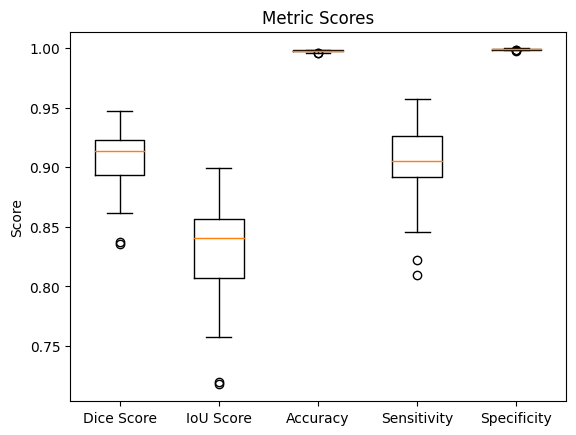

In [23]:
metric_scores = [dice_scores, iou_scores, accuracy_scores, sensitivity_scores, specificity_scores]

plt.boxplot(metric_scores, labels=['Dice Score', 'IoU Score', 'Accuracy', 'Sensitivity', 'Specificity'])
plt.ylabel('Score')
plt.title('Metric Scores')
plt.savefig("plot/skenario1a-metricfix.png")
plt.show()

### Visualization

In [74]:
IDX = 7
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["MRI"]["data"]

grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 64, (8, 8, 8))


In [75]:
aggregator = tio.inference.GridAggregator(grid_sampler)

In [76]:
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

In [77]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   24000 KB |  312837 KB |    1070 MB |    1046 MB |\n|       from large pool |   20480 KB |  307524 KB |    1055 MB |    1035 MB |\n|       from small pool |    3520 KB |    9991 KB |      14 MB |      11 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   24000 KB |  312837 KB |    1070 MB |    1046 MB |\n|       from large pool |   20480 KB |  307524 KB |

In [78]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['MRI']["data"].to(device)
        locations = patches_batch[tio.LOCATION]  
        pred = model(input_tensor)  
        aggregator.add_batch(pred, locations)  

In [79]:
output_tensor = aggregator.get_output_tensor()  

In [80]:
imgs.shape

torch.Size([1, 64, 64, 64])

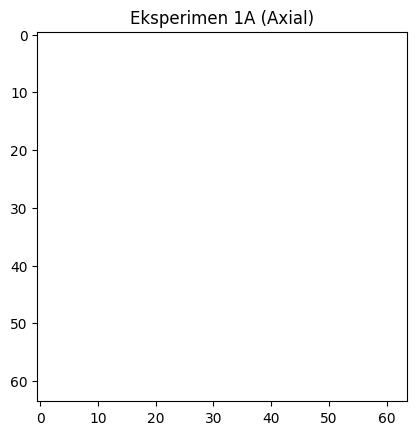

In [81]:
fig = plt.figure()
camera = Camera(fig) 
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2): # axial view  
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.title("Eksperimen 1A (Axial)")
    plt.imshow(label_mask, alpha=0.5, cmap="winter")  
    plt.imshow(mask_, alpha=0.5, cmap="autumn")    
    
    camera.snap()  
animation = camera.animate()  

In [82]:
HTML(animation.to_html5_video())  

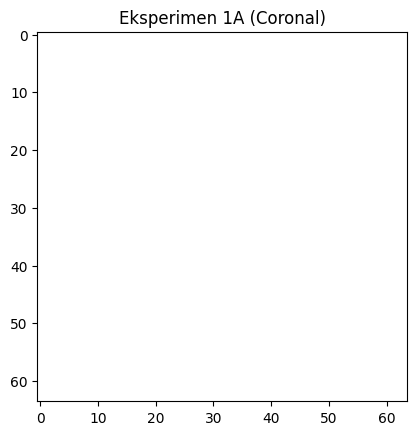

In [83]:
fig = plt.figure()
camera = Camera(fig) 
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2): # coronal view  
    plt.imshow(imgs[0,:,i,:], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,i,:]==0, pred[:,i,:])
    label_mask = np.ma.masked_where(mask[0,:,i,:]==0, mask[0,:,i,:])
    plt.title("Eksperimen 1A (Coronal)")
    plt.imshow(label_mask, alpha=0.5, cmap="winter") 
    plt.imshow(mask_, alpha=0.5, cmap="autumn") 

    # plt.axis("off")
    camera.snap()  
animation = camera.animate()  

In [84]:
HTML(animation.to_html5_video()) 

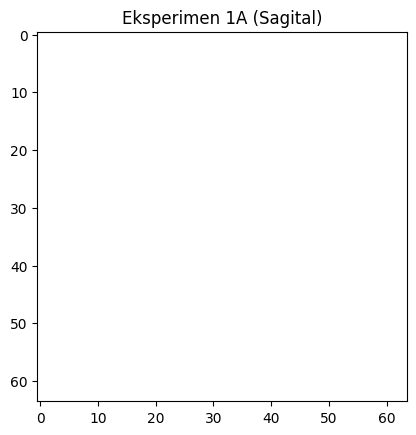

In [85]:
fig = plt.figure()
camera = Camera(fig) 
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2): # sagital view   
    plt.imshow(imgs[0,i,:,:], cmap="bone")
    mask_ = np.ma.masked_where(pred[i,:,:]==0, pred[i,:,:])
    label_mask = np.ma.masked_where(mask[0,i,:,:]==0, mask[0,i,:,:])
    plt.title("Eksperimen 1A (Sagital)")
    plt.imshow(label_mask, alpha=0.5, cmap="winter") 
    plt.imshow(mask_, alpha=0.5, cmap="autumn")   

    # plt.axis("off")
    camera.snap()  
animation = camera.animate() 

In [86]:
HTML(animation.to_html5_video())  

In [ ]:
import vtk

In [96]:
output_array = pred.detach().cpu().numpy()
mask = torch.from_numpy(mask.numpy().squeeze().astype(np.int64)) 
predicted_mask = torch.from_numpy(output_array.squeeze().astype(np.int64))  

img_data = imgs.numpy().squeeze()  
mask_data = predicted_mask.numpy().astype(np.int16)

mask_color = np.zeros_like(img_data, dtype=np.uint8)
mask_color[predicted_mask.numpy() == 1] = 255  

mask_vtk = vtk.vtkImageData()
mask_vtk.SetDimensions(mask_color.shape[0], mask_color.shape[1], mask_color.shape[2])
mask_vtk.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)  
mask_vtk.GetPointData().GetScalars().SetArray(mask_color.ravel(), mask_color.size, 1)

mask_surface = vtk.vtkMarchingCubes()
mask_surface.SetInputData(mask_vtk)
mask_surface.SetValue(0, 128) 

mask_surface.Update()

stl_writer = vtk.vtkSTLWriter()
stl_writer.SetFileName(f"result/stl_worst.stl")
stl_writer.SetInputConnection(mask_surface.GetOutputPort())
stl_writer.Write()

1